In [11]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import load_data, preprocess_data, calculate_mse, build_index_groups
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

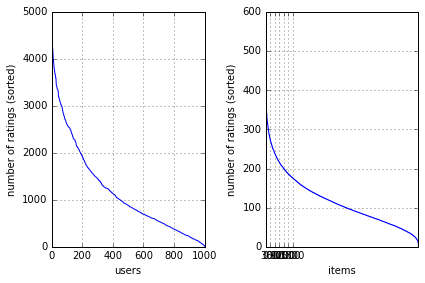

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]

    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    indices = valid_ratings.nonzero()
    
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    for i, j in zip(indices[0], indices[1]):
        r = np.random.random()
        if r < 0.1:
            test[i,j] = valid_ratings[i,j]
        else:
            train[i,j] = valid_ratings[i,j]
    
    print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1058916
Total number of nonzero elements in test data:117957


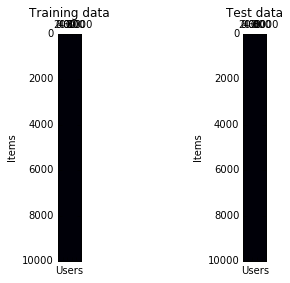

In [7]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

In [8]:
from sklearn.decomposition import NMF
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    model = NMF(n_components=num_features)
    W = model.fit_transform(train, num_features)
    Z = model.components_

    return Z.T, W

In [9]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    
    prediction = item_features.dot(user_features.T)
    pred_new = []
    real_data = []
    for i, j in nz:
        pred_new.append(prediction[i,j])
        real_data.append(data[i,j])
    
    mse = calculate_mse(np.array(real_data), np.array(pred_new))/data.nnz
    return mse

In [15]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.04
    num_features = 5 # K in the lecture notes
    lambda_user = 0.
    lambda_item = 0.3
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        counter = 0
        prediction = item_features.dot(user_features.T)
        for d, n in nz_train:

            g_w = (train[d, n] - item_features[d].dot(user_features[n].T))*(user_features[n,:])
            g_w = - (g_w - (lambda_item * item_features[d,:]))
            g_z = (train[d, n].T - item_features[d].dot(user_features[n].T).T)*(item_features[d,:])
            g_z = - (g_z - (lambda_user * user_features[n,:]))
            
            g_w = np.squeeze(np.asarray(g_w))
            g_z = np.squeeze(np.asarray(g_z))
            
            item_features[d,:] -= gamma*g_w
            user_features[n,:] -= gamma*g_z
            
        
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 0.5735889686015327.
iter: 1, RMSE on training set: 0.5568016827805361.
iter: 2, RMSE on training set: 0.5480562490109298.
iter: 3, RMSE on training set: 0.537681710021857.
iter: 4, RMSE on training set: 0.5324506568079007.
iter: 5, RMSE on training set: 0.525534249091079.
iter: 6, RMSE on training set: 0.5207218425493856.
iter: 7, RMSE on training set: 0.517081123630456.
iter: 8, RMSE on training set: 0.5126231184689121.
iter: 9, RMSE on training set: 0.5117872784357499.
iter: 10, RMSE on training set: 0.5084705394544231.
iter: 11, RMSE on training set: 0.5069446117214629.
iter: 12, RMSE on training set: 0.5056286218687428.
iter: 13, RMSE on training set: 0.5043246708146034.
iter: 14, RMSE on training set: 0.5040400727196432.
iter: 15, RMSE on training set: 0.5030277150190923.
iter: 16, RMSE on training set: 0.5033255295439374.
iter: 17, RMSE on training set: 0.5019439221479467.
iter: 18, RMSE on training set: 0